In [1]:
# Importing the required Modules

import numpy as np
import torch
from torch import  nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim

In [2]:
# List of Tranforms to be applied on the Training Set
# Some of the Training Images will be randomly flipped Vertically and Horizontally so as to make it diffcult for the model to remember the training examples and in turn forcing it to generalize  
transforms_tr = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip()]) 

# Converting the test set to a Tensor
transforms_te = transforms.Compose([transforms.ToTensor()]) 

In [3]:
# Importing the datasets for both training and testing
# MNIST is already provided by PyTorch

trainset = datasets.MNIST('/data', train=True, download=True, transform=transforms_tr)
testset = datasets.MNIST('/data', train=False, download=True, transform=transforms_te)


Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw




Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw




Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw




Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
import random

# Defining the validation dataset percentage. Here 20%
valid_pct = 0.2

# Generating a list of indices of the length of the training set and shuffling them 
indices = [i for i in range(len(trainset))]
random.shuffle(indices)

# Splitting the indices into training and validation 
idx = int(valid_pct * len(trainset))
valid_idx, train_idx = indices[:idx], indices[idx :]

In [5]:
# Randomly samples from the training indices
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)

# Randomly samples from the validation indices
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [6]:
# Using PyTorch's custom Data Loader to load the training, validation and test test
# Batch Size = 32

train_loader = torch.utils.data.DataLoader(trainset, batch_size = 32, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size = 32, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 32 )

### Visualizing the Digits

In [7]:
import matplotlib.pyplot as plt

% matplotlib inline

In [8]:
# Creating a classes list to label each each output
classes = [str(i) for i in range(10)]

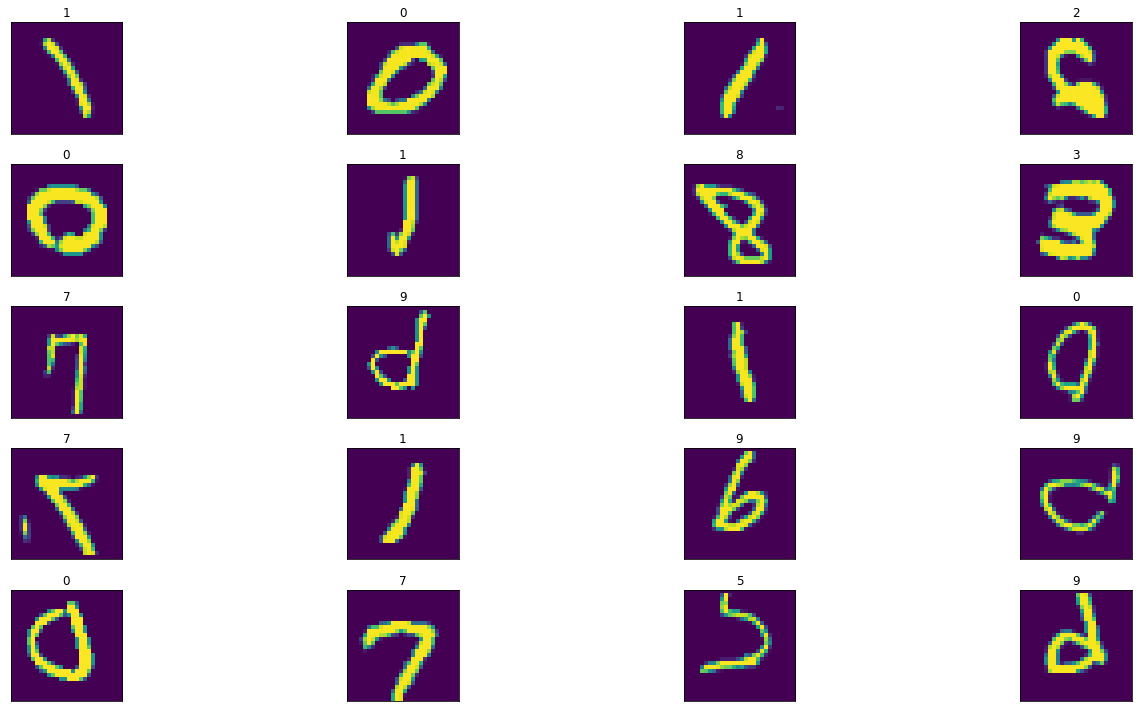

In [9]:
# Loading a set of images and labels from train loader
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(25,10))

# Printing the Images along with their Labels
for idx in np.arange(20):
  ax = fig.add_subplot(5, 4, idx+1, xticks = [], yticks = [])
  plt.imshow(images[idx].numpy().squeeze())
  ax.set_title(classes[labels[idx]])
  fig.tight_layout()

### Defining the Model

I will be using a Fully Connected 5 layer Neural Network to train the model. This model will also include some dropout layers with probability 0.2 to prevent overfitting of the model

The activation function for the first four fully connected layers will be ReLu or the rectified linear activation function. 

The final layer will have the LogSoftmax activation function. Hence the predictions will be Logits and we will have to take exponential to get actual class probabilities


In [10]:
# Building a Fully Connected Neural Network with 5 Layers

class Network(nn.Module):

  def __init__(self):
    '''
    The init function is where you define the layers of the model
    
    self.fc1 ---> Takes the 28*28 by input image as a vector and has 1024 output units
    self.fc2 ---> Takes 1024 input units and 1024 output units
    self.fc3 ---> Takes 1024 input units and 1024 output units
    self.fc4 ---> Takes 1024 input units and 1024 output units
    self.fc5 ---> Takes 1024 input units and 10 output units, each for one class (0-9)
    
    '''    
    super().__init__()

    self.fc1 = nn.Linear(28*28, 1024)
    self.fc2 = nn.Linear(1024, 1024)
    self.fc3 = nn.Linear(1024, 1024)
    self.fc4 = nn.Linear(1024, 1024)
    self.fc5 = nn.Linear(1024, 10)

    self.dropout = nn.Dropout(p = 0.2)

  def forward(self, x):
    
    '''
    Function to actually train the model
    x - input image which will pass through all the layers defined in the model and some dropout layers 
    '''
    x = x.view(-1, 28*28)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = F.relu(self.fc4(x))
    x = self.dropout(x)
    x = F.log_softmax(self.fc5(x), dim = 1)

    return x


In [11]:
from torchsummary import summary

# Creating an object of the Network class

model = Network().cuda()

# Displaying the model summary 

summary(model, images.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         803,840
           Dropout-2                 [-1, 1024]               0
            Linear-3                 [-1, 1024]       1,049,600
           Dropout-4                 [-1, 1024]               0
            Linear-5                 [-1, 1024]       1,049,600
           Dropout-6                 [-1, 1024]               0
            Linear-7                 [-1, 1024]       1,049,600
           Dropout-8                 [-1, 1024]               0
            Linear-9                   [-1, 10]          10,250
Total params: 3,962,890
Trainable params: 3,962,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.06
Params size (MB): 15.12
Estimated Total Size (MB): 15.28
-------------------------------------

### Training the Model

In [ ]:
I will be using the negative log likelihood loss which will be minimized using the Adam Optimizer.

In [12]:
# The loss function, optimizer and learning rate are defined

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [13]:
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
# Defining the number of Eopchs and training the model on Training and Validation Set
epochs = 60


valid_loss_min = float("inf")
    
for iterations in range(epochs):

    train_loss = 0
    validation_loss = 0
    
    
    # Training the model
    model.train()
    for images, labels in train_loader:
        
        # Moving the tensors to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        # Clearing the gradient so previous one doesn't accumulate
        optimizer.zero_grad()
        
        # Making the predictions, checking the loss and updating the parameters uing Back Propagation 
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        # Updating the training loss 
        train_loss += loss.item()*images.size(0)
        
        
    
    # Validating the model
    model.eval()
    for images_v, labels_v in valid_loader:

        # Moving the tensors to GPU
        images_v = images_v.to(device)
        labels_v = labels_v.to(device)            
        

         # Making the predictions, checking the loss
        preds_v = (model.forward(images_v))
        loss = criterion(preds_v, labels_v)
        validation_loss += loss.item() * images_v.size(0)
    
    # Average Loss:
    train_loss = train_loss/ len(train_loader.sampler)
    validation_loss = validation_loss/ len(valid_loader.sampler)
        

    # Printing the Training and Validation Loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        iterations, train_loss, validation_loss))
        
    # Saving the model if Validation Loss has decreased
    
    if validation_loss < valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        validation_loss))
        torch.save(model.state_dict(), "MNIST_fc.pt")
        valid_loss_min = validation_loss

Epoch: 0 	Training Loss: 0.641613 	Validation Loss: 0.273098
Validation loss decreased (inf --> 0.273098).  Saving model ...
Epoch: 1 	Training Loss: 0.286537 	Validation Loss: 0.208201
Validation loss decreased (0.273098 --> 0.208201).  Saving model ...
Epoch: 2 	Training Loss: 0.227651 	Validation Loss: 0.185536
Validation loss decreased (0.208201 --> 0.185536).  Saving model ...
Epoch: 3 	Training Loss: 0.196897 	Validation Loss: 0.155646
Validation loss decreased (0.185536 --> 0.155646).  Saving model ...
Epoch: 4 	Training Loss: 0.171863 	Validation Loss: 0.146245
Validation loss decreased (0.155646 --> 0.146245).  Saving model ...
Epoch: 5 	Training Loss: 0.155139 	Validation Loss: 0.133780
Validation loss decreased (0.146245 --> 0.133780).  Saving model ...
Epoch: 6 	Training Loss: 0.143219 	Validation Loss: 0.125557
Validation loss decreased (0.133780 --> 0.125557).  Saving model ...
Epoch: 7 	Training Loss: 0.133042 	Validation Loss: 0.124755
Validation loss decreased (0.12555

In [15]:
# Loading the last saved version of the Model

model.load_state_dict(torch.load("MNIST_fc.pt"))

<All keys matched successfully>

In [50]:
# Function to define the accuracy of the model

def check_accuracy(loader, model):
    '''
      Loader: Training Loader/Testing Loader/Validation Loader i.e. to load the images and their corresponding labels
      Model: The defined model for training

    '''
    num_correct = 0
    num_samples = 0
    model.eval()
    
    # Since back propagation is not required, to speed up the computations, setting no_grad
    
    with torch.no_grad():
        for x, y in loader:

            # Moving the tensors to the GPU
            x = x.to(device=device)
            y = y.to(device=device)


            # Making the predictions and counting the number of correct predictions and the total number of samples
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        # Calculating and printing the accuracy

        print("Got {}/{} correct with accuracy {:.2f}" .format(num_correct, num_samples, float(num_correct)/float(num_samples)*100))
    model.train()

In [51]:

# Calculating the Accuracy on test data
check_accuracy(test_loader, model)

Got 9737/10000 correct with accuracy 97.37


In [52]:
# Function to print the input img along with its predicted class probability

def view_image_prob(img, prob):

    # Moving the image and predictions to CPU
    prob = prob.to("cpu")
    img = img.to("cpu")
    prob = prob.data.numpy().squeeze()

    # Creating subplots to print the images
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title("Class Probability")
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


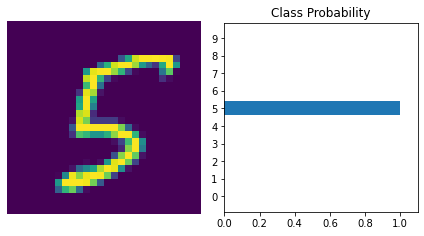

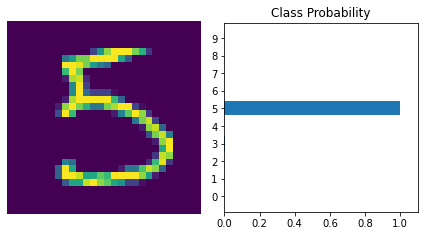

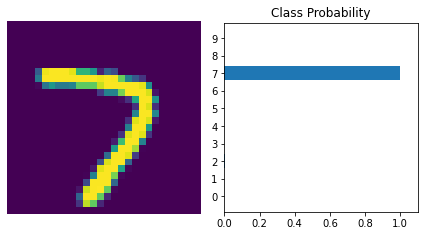

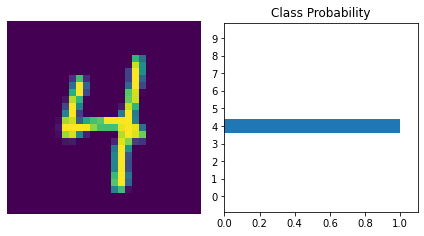

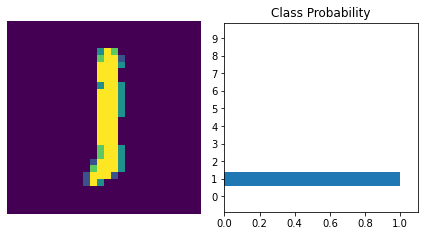

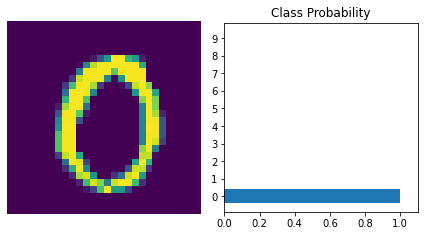

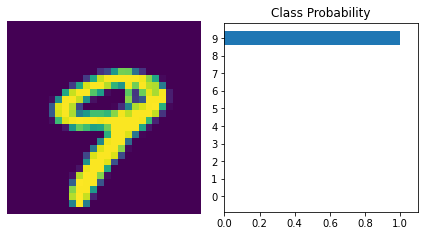

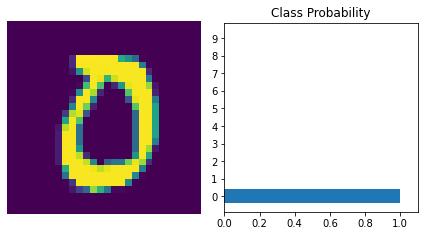

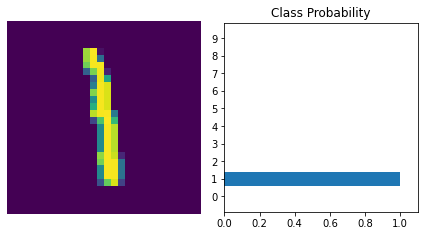

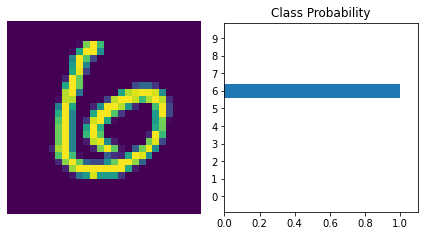

In [53]:
# generating 10 random samples from one batch of the test data and printing the sample and it's predicted class probability

images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

indices_test = list(range(images.shape[0]))
np.random.shuffle(indices_test)
idx = 10
test_set = indices_test[:idx]


# Printing 
for i in test_set:

  test_img = images[i].view(1,784)

  pred = model(test_img)

  # pred contains Logits, need to take softmax to get probabilities
  final_pred = F.softmax(pred)
  
  view_image_prob(test_img, final_pred)

As we can see our model gets all of the random examples correct. 

The testing accuracy is greater than 97%
